In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.progress_bar

In [2]:
num_qubits = 2
num_layers = 2
thetas = np.ones((num_qubits*num_layers*5))
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=100, disable=False)
for i in range(0, 100):
    bar.update(1)
    G = qtm.fubini_study.calculate_koczor_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_koczor, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_koczor(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")


Step: 100%|██████████| 100/100 [11:22<00:00,  6.83s/it]


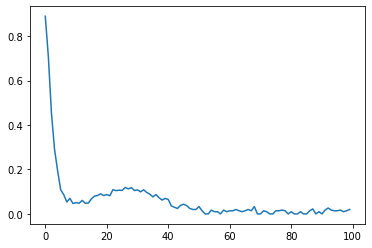

In [3]:
plt.plot(loss_values)

In [4]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_koczor_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_ghz_state(qc1, theta)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")